In [1]:
import yaml
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [2]:
from matplotlib.ticker import PercentFormatter
from matplotlib.gridspec import GridSpec

In [3]:
from sklearn.preprocessing import MinMaxScaler

In [4]:
from utils.datautils import load_xor_blobs, DataCard

/Users/tomastokar/anaconda3/envs/PyBreclipCPU/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<br>

# 1. XOR Blobs experiment

<br>

Read obtained experimental results

In [5]:
fn = './results/xor_blobs_experiment.csv'
results = pd.read_csv(fn, index_col = 0)

<br>

Add imputation score

In [6]:
f = lambda x: (x - x.min())/(x.max() - x.min())
g = lambda x: 1. - f(x)

In [7]:
cat_cols = ['c']
num_cols = ['x', 'y']

funcs = {}
for col in cat_cols:
    funcs[col] = f
for col in num_cols:
    funcs[col] = g

results['imputation_score'] = results.apply(funcs).mean(axis = 1)

<br>

Print best results per target var per method

In [8]:
table = (
    results
    .sort_values('imputation_score', ascending = False)
    .drop_duplicates(subset = 'model_type')
    .loc[:,['model_type', 'c', 'x', 'y', 'imputation_score']]
    .set_index('model_type')
)

In [9]:
table

,c,x,y,imputation_score
model_type,,,,
ICEH,0.900000,0.008238,0.005902,0.981982
MCN,0.733333,0.178904,0.147640,0.588745
GMC,0.683333,0.206420,0.121908,0.565050
CLIP,0.750000,0.270556,0.105913,0.561591


<br>

Export to tex file

In [10]:
(
    table
    .style
    .format(precision = 3)
    .to_latex(
        './tables/synthetic_data_experiments_summary.tex', 
        hrules = True, 
        # column_format="l|rrrr"
    )
)

<br>

# 2. Real-world data experiments

<br>

### Process results

<br>

Read datacards

In [11]:
with open('./src/datacards.yml', 'r') as f:
    datacards = yaml.load(f, Loader=yaml.FullLoader)          
    datacards = {
        n:DataCard(**dc) for n, dc in datacards.items() 
        if n != 'xor_blobs'
    }

<br>

Read datasets characteristics

In [12]:
# Read data stats
datastats = (
    pd
    .read_csv('./src/data_stats.csv', index_col = 0, low_memory = False)
    .reset_index()
)


# Rename columns
datastats = datastats.rename(
    columns = {
        'index' : 'Name',
        'prediction_task' : 'Prediction task',
        'num_samples' : 'Samples'
        
    }
)

# Calc. total number of variables
datastats['Variables'] = (
    datastats
    .iloc[:,3:]
    .astype(int)
    .sum(axis = 1)
)

# Select columns
datastats = datastats[['Prediction task', 'Name', 'Samples', 'Variables']]

<br>

Read results of CRL experiments and associated benchmarks

In [13]:
experiments = {}
for dataset_name in datacards.keys():

    # Read data
    fn = './results/{}_experiment.csv'.format(dataset_name)     
    try:        
        r = pd.read_csv(fn, index_col = 0)
    except:
        print(fn)
        continue
        
    fn = './results_benchmark/{}_benchmark.csv'.format(dataset_name)             
    try:        
        b = pd.read_csv(fn, index_col = 0).iloc[:,1:].mean(axis = 0).to_frame().T
                
        # Indicate benchmark as a model type
        b['model_type'] = 'benchmark'

        # Add to experiment results
        experiments[dataset_name] = pd.concat([r, b])
        
    except:
        print(fn)
        experiments[dataset_name] = r        

./results_benchmark/kickstarter_benchmark.csv
./results_benchmark/clothing_benchmark.csv
./results_benchmark/streetview_benchmark.csv
./results_benchmark/skin_cancer_benchmark.csv


<br>

Calculate overal score to evaluate imputation task performance

In [14]:
f = lambda x: (x - x.min())/(x.max() - x.min())
g = lambda x: 1. - f(x)

In [15]:
keep_cols = [
    'batch_size', 'learning_rate', 'latent_dim', 'model_type',
    'embedder_params', 'predictor_params', 'kmeans_perf', 'knn_perf',
    'predictor_perf', 'imputation_perf'
]

for n, r in experiments.items():

    # Select datacard
    datacard = datacards[n]
    
    funcs = {}
    for col in datacard.features:
        if col in r.columns:
            if col in datacard.cat_vars:
                funcs[col] = f        
            elif col in datacard.num_vars:
                funcs[col] = g    
    
    r['imputation_perf'] = r.apply(funcs).mean(axis = 1)
    
    experiments[n] = r.loc[:, keep_cols]

<br>

Concat into a single data frame

In [16]:
experiments = (
    pd
    .concat(experiments)
    .reset_index(level=0)
    .rename(columns = {'level_0': 'dataset'})
)

<br>

Fix nomenclature to match the paper

In [17]:
experiments = pd.merge(
    datastats, 
    experiments, 
    left_on = 'Name', 
    right_on = 'dataset'
)

In [18]:
experiments = experiments.rename(
    columns = {
        'model_type' : 'Method' 
    }
)

In [19]:
experiments['Method'] = experiments['Method'].map(
    {
        'ICEH' : 'ICE-T',
        'SUBTAB' : 'SubTab',
        'SCARF' : 'Scarf',
        'CLIP' : 'CLIP',
        'GMC' : 'GMC',
        'MCN' : 'MCN',
        'CONTROL' : 'Control',
        'benchmark' : 'Benchmark',
        
    }
)

<br>

### Prepare task-specific performance tables

In [20]:
methods = ['Benchmark', 'Control', 'Scarf', 'SubTab', 'CLIP', 'GMC', 'MCN', 'ICE-T']

In [21]:
performance = {}

In [22]:
performance['Imputation'] = (
    experiments
    .groupby(['Name', 'Method'])['imputation_perf']
    .max()
    .reset_index()
    .pivot(index = 'Name', columns = 'Method', values = 'imputation_perf')
    .loc[:,methods]
    .drop(columns = ['Benchmark', 'Control'])
)

In [23]:
performance['Clustering'] = (
    experiments
    .groupby(['Name', 'Method'])['kmeans_perf']
    .max()
    .reset_index()
    .pivot(index = 'Name', columns = 'Method', values = 'kmeans_perf')
    .loc[:,methods]    
    .drop(columns = ['Control'])
)

<br>

Performance in supervised learning

In [24]:
knn_perf = {}
for task, r in experiments.groupby('Prediction task'):
    
    if task == 'classification':
                
        knn_perf[task] = (
            r
            .groupby(['Name', 'Method'])['knn_perf']
            .max()
            .reset_index()
            .pivot(index = 'Name', columns = 'Method', values = 'knn_perf')
            .loc[:,methods]            
            .drop(columns = ['Control'])
        ) * 100.0 # Express accuracies as percentage
        
    else:
        
        knn_perf[task] = (
            r
            .groupby(['Name', 'Method'])['knn_perf']
            .min()
            .reset_index()
            .pivot(index = 'Name', columns = 'Method', values = 'knn_perf')
            .loc[:,methods]
            .drop(columns = ['Control'])           
        )

performance['Supervised learning'] = pd.concat(knn_perf)

<br>

Performance in transfer learning

In [25]:
predictor_perf = {}
for task, r in experiments.groupby('Prediction task'):
    if task == 'classification':        
        predictor_perf[task] = (
            r
            .groupby(['Name', 'Method'])['predictor_perf']
            .max()
            .reset_index()
            .pivot(index = 'Name', columns = 'Method', values = 'predictor_perf')      
            .loc[:,methods]
        ) * 100.0
        
    else:        
        predictor_perf[task] = (
            r
            .groupby(['Name', 'Method'])['predictor_perf']
            .min()
            .reset_index()
            .pivot(index = 'Name', columns = 'Method', values = 'predictor_perf')            
            .loc[:,methods]            
        )      

performance['Transfer learning'] = pd.concat(predictor_perf)

In [26]:
for n, p in performance.items():
    (
        p
        .style
        .format(precision = 5, na_rep = '')
        .to_latex('./tables/{}.tex'.format(n.replace(' ', '_')), hrules = True)
    )

<br>

### Prepare relative ([0,1] scaled) performance

In [27]:
f = lambda x: (x - x.min())/(x.max() - x.min())
g = lambda x: 1. - f(x)

In [28]:
performance_relative = {}
for task, p in performance.items():
    
    if task in ['Imputation', 'Clustering']:
        performance_relative[task] = p.apply(f, axis = 1)
    
    else:
        performance_relative[task] = pd.concat(
            [
                p.loc['classification'].apply(f, axis = 1),
                p.loc['regression'].apply(g, axis = 1)                        
            ]
        )

<br>

## Compute winnner-looser matrices

In [29]:
win_mats = {}
for t, p in performance_relative.items():
    cols = p.columns
    n = len(cols)
    wm = pd.DataFrame(
        np.zeros((n, n)), 
        index = cols, 
        columns = cols
    )
    
    for col_1 in cols:
        for col_2 in cols:
            if col_1 != col_2:
                pp = p[[col_1, col_2]].dropna()
                wm.loc[col_1, col_2] = np.mean(pp[col_1] > pp[col_2])
            else:
                wm.loc[col_1, col_2] = np.nan 
                
    win_mats[t] = wm

<Figure size 640x480 with 0 Axes>

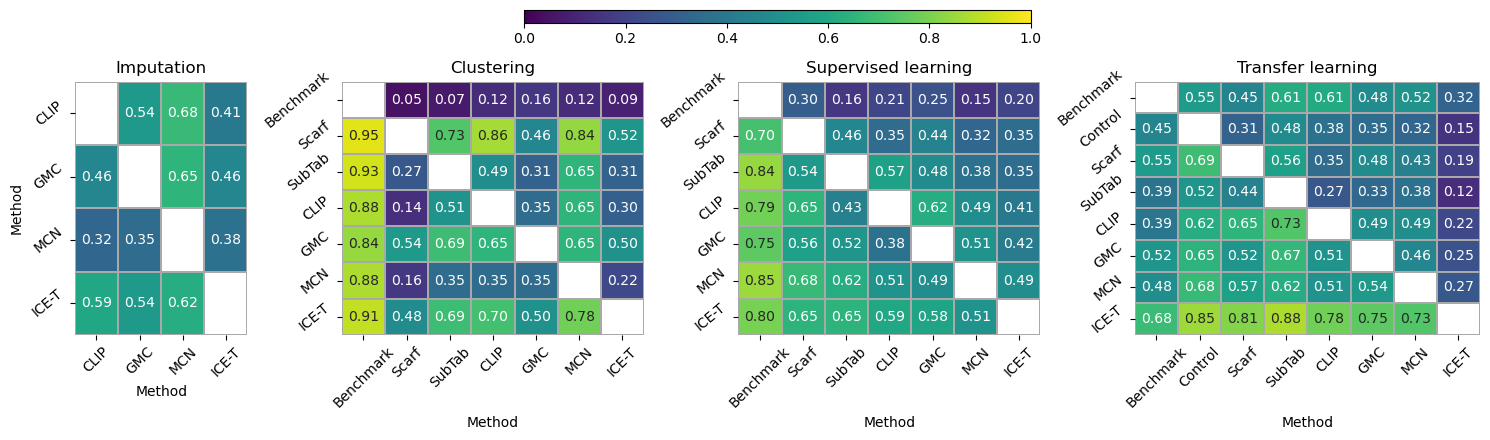

In [30]:
plt.clf()
fig = plt.figure(
    layout="tight", 
    figsize = (15, 4.5)
)

gs = GridSpec(
    2, 4, 
    figure=fig,
    width_ratios = [4,7,7,8],
    height_ratios = [0.05, 1.0]    
)

cbax = fig.add_subplot(gs[0, :])
axes = [fig.add_subplot(gs[1, i]) for i in range(4)]

for i, (t, wm) in enumerate(win_mats.items()):

    if t == 'Imputation':
        wm = wm.drop(
            columns = ['Scarf', 'SubTab'],
            index = ['Scarf', 'SubTab'],            
        )
    
    pcm = sns.heatmap(
        wm, 
        annot = wm.values,
        fmt='.2f',
        ax = axes[i],
        vmin = 0.,
        vmax = 1.,
        cbar = False,
        cmap = 'viridis',
        linewidths=.25, 
        linecolor='darkgrey'    
    )
    
    axes[i].set_title(t)

cbax.set_aspect(0.025)
fig.colorbar(
    axes[3].collections[0], 
    cax=cbax,
    orientation = 'horizontal',
)

for i, ax in enumerate(axes):
    if i != 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('Method')
    ax.set_xlabel('Method')
    
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_va('top')
        
    for label in ax.get_yticklabels():
        label.set_rotation(40)
        label.set_ha('right')        

# plt.tight_layout()
plt.savefig('./figures/winmats.png')
plt.show()

<br>

### Prepare relative ([0,1] scaled) performance (excluding benchmarks and controls)

In [31]:
f = lambda x: (x - x.min())/(x.max() - x.min())
g = lambda x: 1. - f(x)

In [32]:
drop_cols = ['Benchmark', 'Control']
performance_relative = {}
for task, p in performance.items():
    p = p.drop(columns = drop_cols, errors = 'ignore')
    
    if task in ['Imputation', 'Clustering']:
        performance_relative[task] = p.apply(f, axis = 1)
    
    else:
        performance_relative[task] = pd.concat(
            [
                p.loc['classification'].apply(f, axis = 1),
                p.loc['regression'].apply(g, axis = 1)        
                
            ]
        )

<br>

### Plot relative performance tables

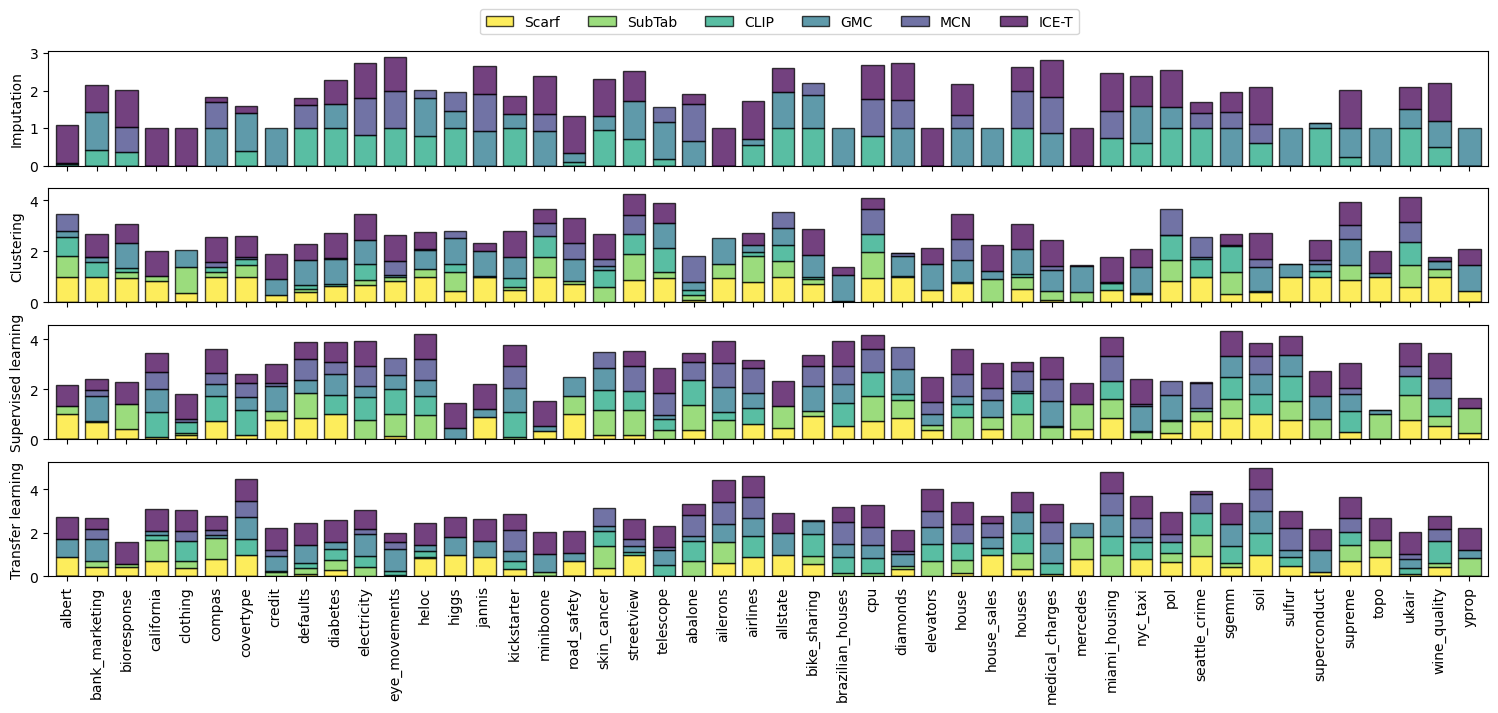

In [33]:
fig, axes = plt.subplots(4, 1, figsize = (15, 7.5), sharex = True)

for i, (task, p) in enumerate(performance_relative.items()):
    axes[i].set_ylabel(task)
    p.plot.bar(
        ax = axes[i],
        width=0.75,
        alpha = 0.75,
        stacked=True,
        edgecolor = 'k',
        colormap = 'viridis_r' #'tab10'    
        # legend = False
    )
# axes[3].tick_params(axis='x', labelrotation=75)
axes[3].set_xlabel(None)
h, l = axes[0].get_legend_handles_labels()
for ax in axes: ax.get_legend().remove()
plt.legend(h,l, loc=(0.30, 4.75), ncol = 6)
plt.subplots_adjust(left=0.03, right=0.99, top=0.925, bottom=0.225)
plt.savefig('./figures/relative_performance.png')
plt.show()

<br>

## Prepare final table with (average scaled peformance)

In [34]:
grand_table = pd.concat(
    {
        task : p.mean(axis = 0) for task, p in performance_relative.items()
    }
)

In [35]:
grand_table = (
    grand_table
    .to_frame(name = 'Average Ranking')
    .reset_index('Method')
    .pivot(
        columns = 'Method', 
        values = 'Average Ranking'
    )
    .loc[
        ['Imputation', 'Clustering', 'Supervised learning', 'Transfer learning'],
        ['Scarf', 'SubTab', 'CLIP', 'GMC', 'MCN', 'ICE-T']
    ]
    .T
)

In [36]:
grand_table

,Imputation,Clustering,Supervised learning,Transfer learning
Method,,,,
Scarf,NaN,0.673581,0.434433,0.473789
SubTab,NaN,0.344358,0.522024,0.331661
CLIP,0.561092,0.345246,0.570701,0.544238
GMC,0.544324,0.552773,0.494817,0.544123
MCN,0.378225,0.306007,0.636304,0.533459
ICE-T,0.607545,0.617014,0.686998,0.823697


In [37]:
(
    grand_table
    .style
    .format(precision = 3)
    .to_latex(
        './tables/grand_table.tex', 
        hrules = True, 
        # column_format="rrrrr"
    )
)

---